# Учебный проект 13_Прогнозирование температуры звезды

## Содержание

* [Описание проекта](#Описание)
* [Импорт библиотек Python](#Импорт)
* [Загрузка данных](#Загрузка)
* [Предобработка данных](#Предобработка)
* [Исследовательский анализ данных](#Исследование)
    * [Анализ категорильных показателей](#Исследование_качество)
    * [Анализ количественных показателей](#Исследование_количество)
* [Корреляционный анализ данных](#Корреляция)
* [Построение моделей машинного обучения](#Моделирование)
    * [Подготовка данных](#Моделирование_подготовка)
    * [Построение baseline-модели прогнозирования на базе нейронной сети](#Моделирование_baseline)
    * [Построение улучшенной модели нейронной сети](#Моделирование_улучшение)
        * [Изменение размера батчей](#Моделирование_улучшение_батчи)
        * [Метод Batch Normalization](#Моделирование_улучшение_BatchNorm)
        * [Метод Dropout](#Моделирование_улучшение_dropout)
* [Общий вывод](#Вывод)

## Описание проекта <a class = 'anchor' id = 'Описание'></a>

На исследовании находятся данные с `показателями космических объектов, - звезд` - которые были предоставлены руководством компании "Небо на ладони".

---

`Задача`

Разработать модель нейронной сети для **прогнозирования температуры на поверхности звезды**.

---

`Путь решения`

1. Собрать данные с характеристиками звезд;
2. Провести предобработку значений в наборах данных;
3. Провести исследовательский анализ данных для выявления закономерностей, применимых к последующей настройке модели нейронной сети;
4. Подготовить выборки для обучения моделей;
5. Построить baseline модели нейронной сети для получения предварительных результатов;
6. Подготовить улучшенную версию нейронной сети с перебором следующих параметров:
    * Dropout;
    * BatchNormalization;
    * Размер батча.
7. Сформировать вывод о подготовленных решениях. Выполнить сравнение двух версий модели нейронной сети.

---

`Располагаемые данные`

**Данные, описывающие показатели звезд**

* Относительная светимость L/Lo - светимость звезды относительно Солнца;
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
* Абсолютная звездная величина Mv — физическая величина, характеризующая блеск звезды;
* Звездный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
* Тип звезды:

|Тип звезды|Номер, соответствующий типу|
|----------|---------------------------|
|Коричневый карлик|0|
|Красный карлик|1|
|Белый карлик|2|
|Звезды главной последовательности|3|
|Сверхгигант|4|
|Гипергигант|5|

**Целевой признак**
* Абсолютная температура Т(К) - температура поверхности звезды в Кельвинах.

**Справочная информация**
* Светимость Солнца (Lo) = 3.828 * 10**26;
* Радиус Солнца (Ro) = 6.9551 * 10**8.

## Импорт библиотек Python <a class = 'anchor' id = 'Импорт'></a>

1. Импорт библиотек Python:
    * для манипулирования данными;
    * для визуализации данных;
    * для решения задач машинного обучения:
        * механизмы построения нейронных сетей;
        * метрики оценки эффективности моделей;
        * механизмы отбора данных;
        * механизмы подготовки данных.
2. Инициализация переменных-констант для последующего использования на этапе построения моделей МО;
3. Формирование вывода по итогам данного этапа.

In [1]:
# импорт библиотек python

# для манипулирования данными
import pandas as pd
import numpy as np

# для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# установка размеров для последующих графиков в проекте
plt.rcParams['figure.figsize'] = (10, 5)

# библиотека математических операций
import math

# вычисление корреляции данных
from phik import phik_matrix

# импорт библиотеки для построения нейронной сети
import torch
import torch.nn as nn

# метрики оценки эффективности моделей
from sklearn.metrics import (mean_squared_error, 
                            root_mean_squared_error)

# механизмы отбора данных и подбора параметров моделей
from sklearn.model_selection import train_test_split

# механизмы подготовки данных
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder)

In [2]:
# инициализация констант для дальнейшего использования в проекте
# инициализация переменной RANDOM_STATE для фиксирования "случайности"
RANDOM_STATE = 42
# инициализация переменной TEST_SIZE для разделения выборки на обучающую и тестовую
TEST_SIZE = 0.25

**Вывод**

1. Импортированы библиотеки Python:
    * для манипулирования данными:
        * pandas;
        * numpy.
    * для визуализации данных:
        * matplotlib.pyplot;
        * seaborn;
        * plotly;
        * dash.
    * для вычисления корреляции данных:
        * phik_matrix.
    * для решения задач машинного обучения:
        * механизмы построения нейронной сети:
            * torch.nn.
        * метрики оценки эффективности моделей классификации;
        * train_test_split - механизм разделения данных;
        * StandardScaler - стандартизация данных;
        * OneHotEncoder - one-hot кодирование категориальных признаков;
        * OrdinalEncoder - кодирование значений ранговых признаков.
2. Инициализированы переменные **RANDOM_STATE** и **TEST_SIZE** для фиксирования "случайности" и размера тестовой выборки.

## Загрузка данных <a class = 'anchor' id = 'Загрузка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Загрузка данных в рабочую среду Jupyter Notebook. Инициализация переменной **stars**;
2. Вывод на экран параметров датасетов:
    * вывод общей структуры набора данных - демонстрация первых 5 строк;
    * общей информации о наборе данных;
    * визуализация распределений количественных показателей.
3. Формирование вывода по итогам данного этапа.

In [3]:
# загрузка данных в рабочую среду

try:
    stars = pd.read_csv('~/Desktop/YandexPraktikum_projects/datasets/6_class.csv')
except:
    stars = pd.read_csv('/datasets/6_class.csv')

In [4]:
# инициализация пользовательской функции для первичного изучения содержимого наборов данных
def first_meeting (df : pd.DataFrame, df_name : str) -> None:
    print(f'Структура набора данных {df_name}')
    display(df.head())
    print('Общая информация о наборе')
    print(df.info())
    print()

In [5]:
# инициализация пользовательской функции построения распределений количественных непрерывных показателей
def num_distribution(df : pd.DataFrame, column : str, bins : int):
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения признака {column}')
    plt.ylabel(f'Частота значений признака')
    plt.title(f'Гистограмма значений {column}', fontsize = 10)
    sns.histplot(df, x = column, bins = bins)
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения признака {column}')
    plt.title(f'Диаграмма размаха значений {column}', fontsize = 10)
    sns.boxplot(df, x = column)
    plt.grid(False)
    plt.show()

In [6]:
# инициализация пользовательской функции построения диаграмм количественных дискретных показателей
def num_countplot(df : pd.DataFrame, column : str):
    sns.countplot(df, x = column)
    plt.title(f'Столбчатая диаграмма значений признака {column}', fontsize = 12)
    plt.xlabel(f'Признак {column}')
    plt.xticks(rotation = 45)
    plt.ylabel(f'Количество значений признака')
    plt.show()

Структура набора данных stars


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB
None



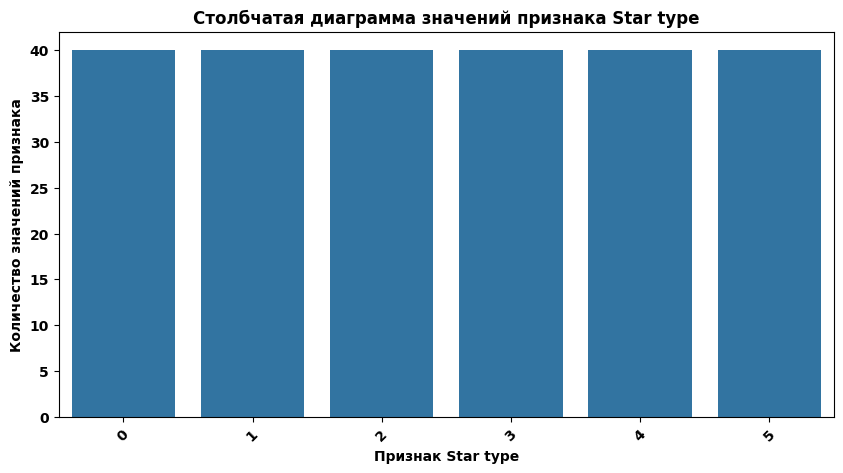

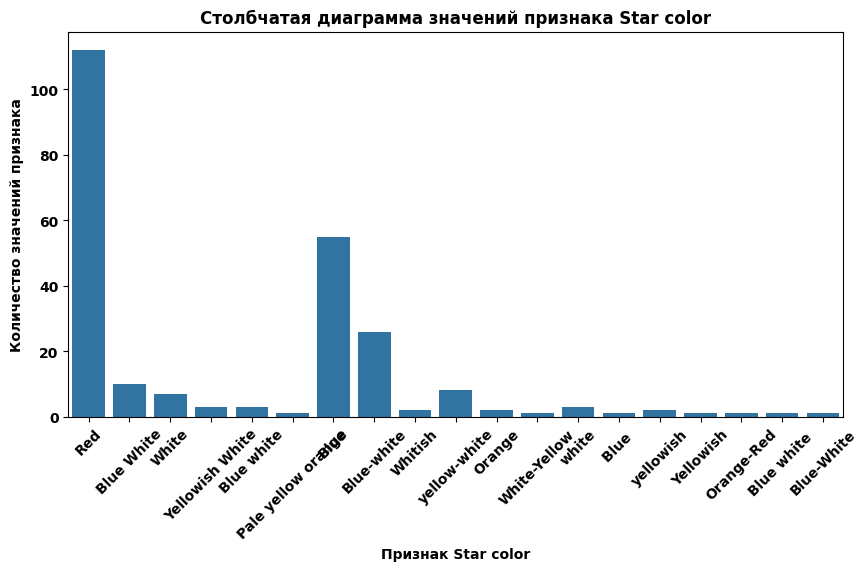

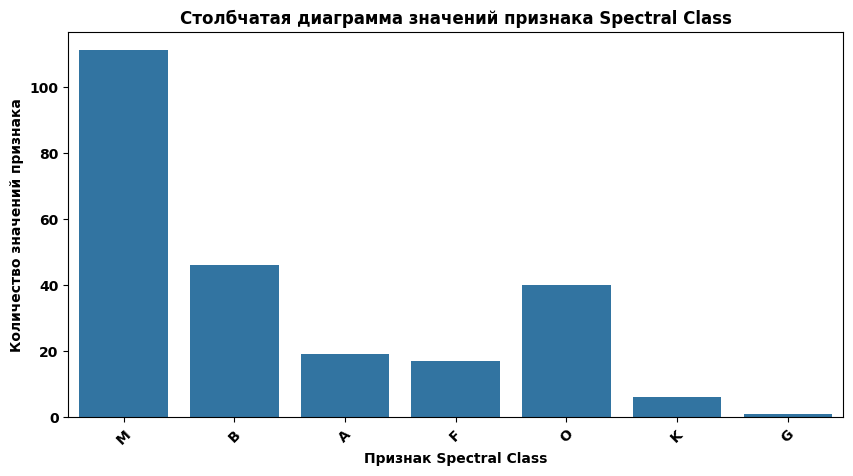

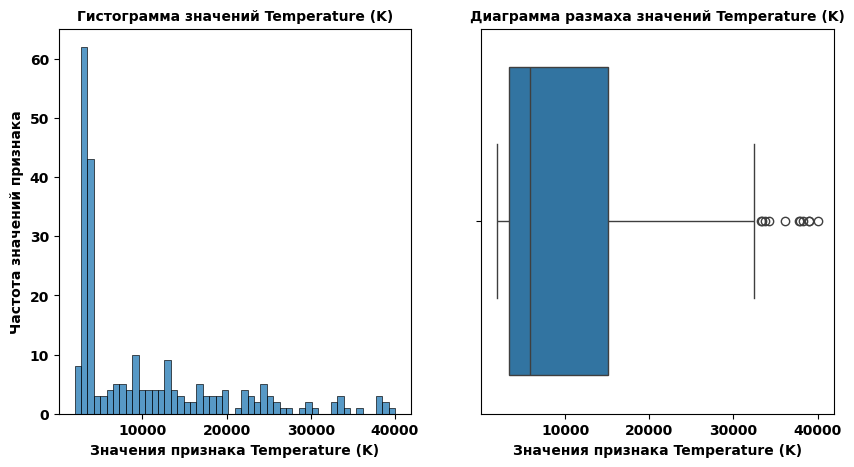

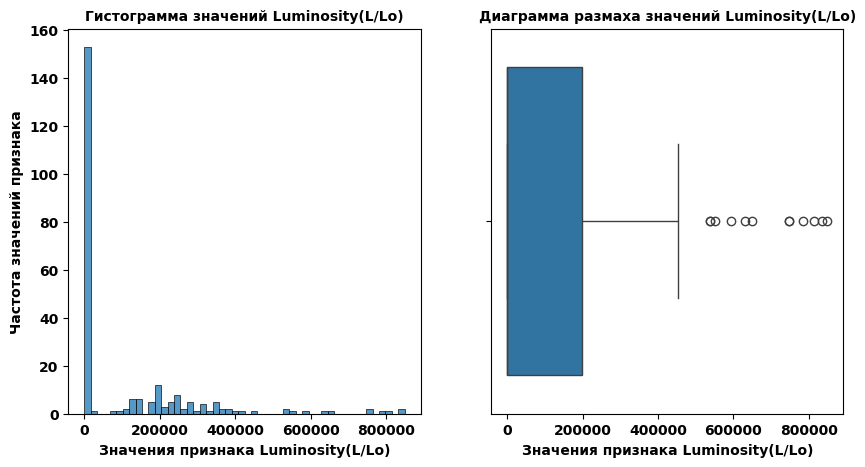

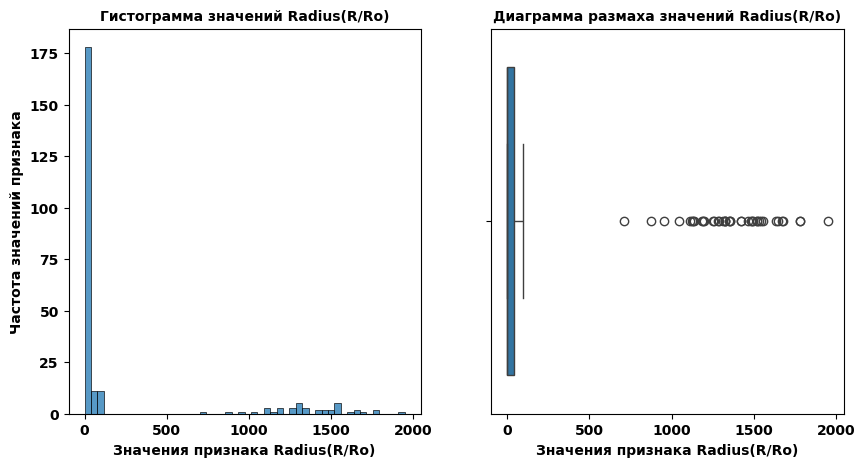

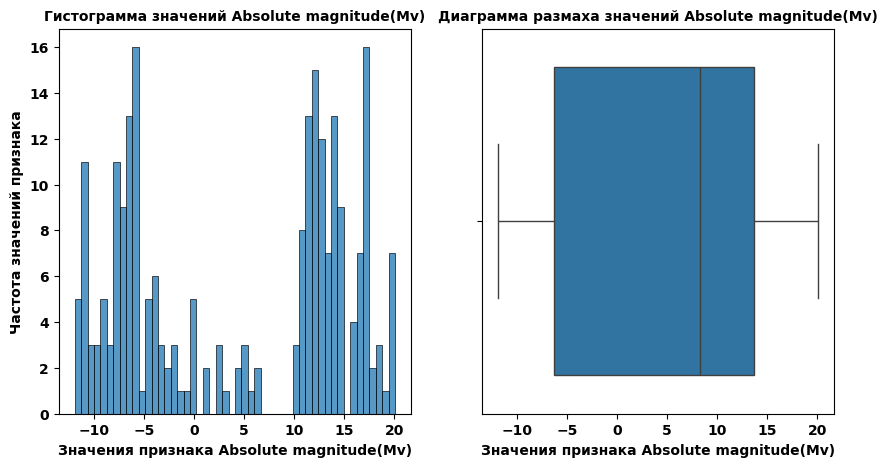

In [7]:
# вывод на экран параметров датасета 'autos'
first_meeting(stars, 'stars')

# вывод на экран графиков дискретных величин по набору 'autos'
for col in ['Star type', 'Star color', 'Spectral Class']:
    num_countplot(stars, col)

# вывод на экран графиков непрерывных количественных величин по набору 'autos'
for col in ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']:
    num_distribution(stars, col, 50)

**Вывод**

1. Произведена загрузка данных в рабочую среду Jupyter Notebook. Инициализирована переменная **stars**;
2. Выведены на экран параметры датасета:
    * В наборе данных **отсутствуют пустые значения** по признакам;
    * Типы данных **соответствуют сущностям значений** по всем рассматриваемым признакам;
    * Названия столбцов **необходимо привести к формату snake_case**;
    * Наблюдаются неявные дубликаты по признаку **Star color**;
    * Наблюдаются выбросы по количественным признакам:
        * **Temperature (K)**;
        * **Luminosity (L/Lo)**;
        * **Radius (R/Ro)**.
    * Самые популярные категории по спектральному классу: **M, B** и **O**;
    * Самые популярные цвета звезд: **Red**, **Pale yellow orange** и **Blue**.

## Предобработка данных <a class = 'anchor' id = 'Предобработка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Приведение названий столбцов к формату snake_case;
2. Обработка неявных дубликатов - значений - по признаку **Star color**;
3. Проверка датасетов на явные дубликаты;
4. Формирование вывода по итогам данного этапа.

In [8]:
# преобразование названий столбцов к формату snake_case
stars.columns = ['_'.join(col.lower().split(' ')) for col in stars.columns]

stars = stars.rename(columns = {
    'temperature_(k)':'temperature',
    'luminosity(l/lo)':'luminosity',
    'radius(r/ro)':'radius',
    'absolute_magnitude(mv)':'absolute_magnitude'
})

In [9]:
# преобразование значений по признаку 'star_color'
stars['star_color'] = (
    stars['star_color']
    .str.lower() # понижение регистра
    .str.strip() # исключение пробелов с конца строк
    .str.replace(' ', '-') # замена знака разделителя
)

# замена значений с перестановкой цвета
for color in ['yellow-white', 'yellowish-white', 'yellowish']:
    stars.loc[stars['star_color'] == color, 'star_color'] = 'white-yellow'

stars.loc[stars['star_color'] == 'whitish', 'star_color'] = 'white'
stars.loc[stars['star_color'] == 'orange-red', 'star_color'] = 'red'
stars.loc[stars['star_color'] == 'pale-yellow-orange', 'star_color'] = 'orange'

In [10]:
# проверка датасета на явные дубликаты
print('Количество явных дубликатов в наборе данных:', stars.duplicated().sum())
print('Доля дубликатов от общего количества записей в наборе: {:.1%}'.format(stars.duplicated().sum() / stars.shape[0]))

Количество явных дубликатов в наборе данных: 0
Доля дубликатов от общего количества записей в наборе: 0.0%


**Вывод**

1. Названия столбцов приведены к формату snake_case;
2. Обработаны неявные дубликаты - значения - по признаку **Star color**:
    * Понижен регистр значений;
    * Удалены пробелы в конце строк;
    * Заменены пробелы на дефис;
    * Заменены значения с перестановкой цвета.
3. Проверка датасетов на явные дубликаты - **Явные дубликаты отсутствуют**;
4. Набор данных подготовлен к дальнейшему исследовательскому анализу.

## Исследовательский анализ данных <a class = 'anchor' id = 'Исследование'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Вывод на экран основной статистической информации по текущим версиям наборов данных;
2. Исследование соотношения количества значений качественных показателей;
3. Исследование распределения количественных показателей наборов. Построение **гистограмм распределения значений**;
4. Формирование вывода по итогам этапа.

In [11]:
# вывод на экран основных статистик по набору 'data'
print(f'Основная статистическая информация по набору data')
stars.describe(include = 'number')

Основная статистическая информация по набору data


,temperature,luminosity,radius,absolute_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


**Вывод по промежуточному этапу**

Набор `stars` характеризуется следующими статистическими показателями:

* **temperature - температура звезды в Кельвинах**:
    * Среднее значение - 10 497.5;
    * Минимальное значение - 1 939.0;
    * Максимальное значение - 40 000.0;
    * Стандартное отклонение - 9 552.4.
* **luminosity - относительная светимость**:
    * Среднее значение - 107 188.4;
    * Минимальное значение - 0.0;
    * Максимальное значение - 849 420.0.
    * Стандартное отклонение - 179 432.2.
* **radius - относительный радиус**:
    * Среднее значение - 237.2;
    * Минимальное значение - 0.0084;
    * Максимальное значение - 1 948.5;
    * Стандартное отклонение - 517.2.
* **absolute_magnitude - абсолютная звездная величина**:
    * Среднее значение - 4.4;
    * Минимальное значение - -11.9;
    * Максимальное значение - 20.1;
    * Стандартное отклонение - 10.5.

In [12]:
# инициализация пользовательской функции по формированию вывода информации

def display_info(df: pd.DataFrame, column_name: str, title: str, xlabel: str, kind_of_plot : str):
# построение визуализации по выбранной метрике
    plt.title(title, fontsize = 12)
    if kind_of_plot == 'pie':
        (df[column_name]
         .value_counts()
         .sort_values(ascending=True)
         .plot(kind = kind_of_plot, figsize = (8, 5), autopct='%1.0f%%'))
    else:
        (df[column_name]
         .value_counts()
         .sort_values(ascending=True)
         .plot(kind = kind_of_plot, figsize = (8, 5)))
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.xlabel(xlabel)
    plt.show()

# построение сводной таблицы по выбранной метрике
    pivot_data = (df[column_name]
                  .value_counts()
                  .sort_values(ascending=False)
                  .to_frame())
    pivot_data['share_of_stars'] = round(pivot_data['count'] / pivot_data['count'].sum() * 100, 2)
    pivot_data.columns = ['count_of_stars', 'share_of_stars']
    display(pivot_data)

In [13]:
# инициализация пользовательской функции по построению гистограмм по передаваемым метрикам
def histogram_plotting(data: pd.DataFrame, feature : str, bins: int, x_size: int, y_size: int, feature_xlabel : str):
    # вычисление статистических метрик для дальнейшей визуализации
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    upper_bound = q3 + 1.5 * (q3 - q1)
    lower_bound = q1 - 1.5 * (q3 - q1)

    # построение визуализации
    plt.figure(figsize = (x_size, y_size))
    plt.hist(data[feature], color = 'blue', edgecolor = 'white', bins = bins)
    plt.axvline(upper_bound, c = 'red', ls = '-', label = 'верхняя граница допустимых значений')
    plt.axvline(q3, c = 'red', ls = '--', label = '3 квартиль значений')
    plt.axvline(q1, c = 'black', ls = '--', label = '1 квартиль значений')
    plt.axvline(lower_bound, c = 'black', ls = '-', label = 'нижняя граница допустимых значений')
    plt.title(f'Гистограмма распределения значений по метрике: {feature_xlabel}', fontsize = 10)
    plt.xlabel(feature_xlabel)
    plt.ylabel('Количество значений по метрике')
    plt.legend(bbox_to_anchor = (1, 0.6))
    plt.show()

    # вывод статистических метрик на экран
    print('Верхняя допустимая граница значений:', upper_bound)
    print('Нижняя допустимая граница значений:', lower_bound)
    print('Медианное значение:', data[feature].median())
    print('Среднее значение:', round(data[feature].mean(), 2))

    # расчет доли аномальных значений по метрике
    print('Доля значений, выходящих за верхнюю границу: {:.2%}'.format(data[data[feature] > upper_bound].shape[0] / data[feature].shape[0]))
    print('Доля значений, выходящих за нижнюю границу: {:.2%}'.format(data[data[feature] < lower_bound].shape[0] / data[feature].shape[0]))

### Анализ категориальных показателей <a class = 'anchor' id = 'Исследование_качество'></a>

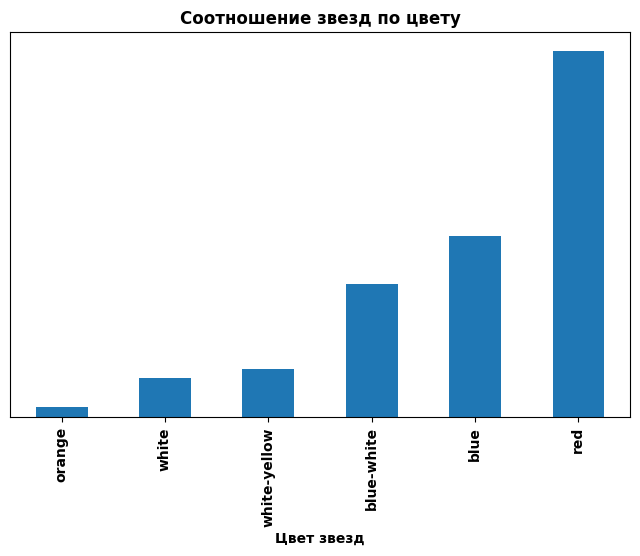

,count_of_stars,share_of_stars
star_color,,
red,113,47.08
blue,56,23.33
blue-white,41,17.08
white-yellow,15,6.25
white,12,5.00
orange,3,1.25


In [14]:
# построение столбчатой диаграммы по соотношению звезд в зависимости от цвета
display_info(stars, 'star_color', 'Соотношение звезд по цвету', 'Цвет звезд', 'bar')

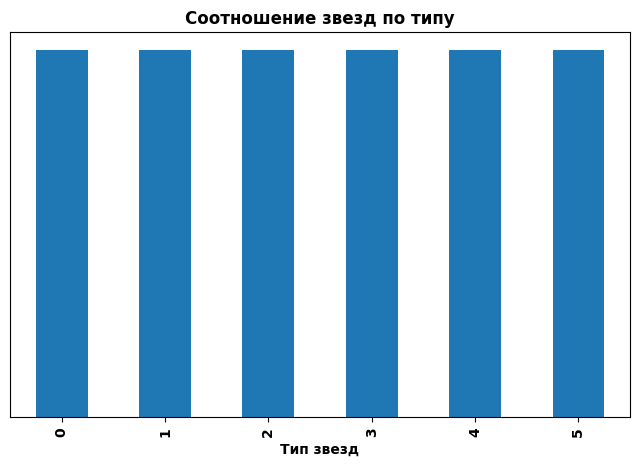

,count_of_stars,share_of_stars
star_type,,
0,40,16.67
1,40,16.67
2,40,16.67
3,40,16.67
4,40,16.67
5,40,16.67


In [15]:
# построение столбчатой диаграммы по соотношению звезд в зависимости от типа
display_info(stars, 'star_type', 'Соотношение звезд по типу', 'Тип звезд', 'bar')

**Вывод по промежуточному этапу**

* Большая часть звезд (87%) представлена тремя основными цветами: **red** (47%), **blue** (23%) и **blue-white** (17%);
* Все звезды распределены в равном отношении друг к другу: **40 представителей в каждом из 6 типов**.

### Анализ количественных показателей <a class = 'anchor' id = 'Исследование_количество'></a>

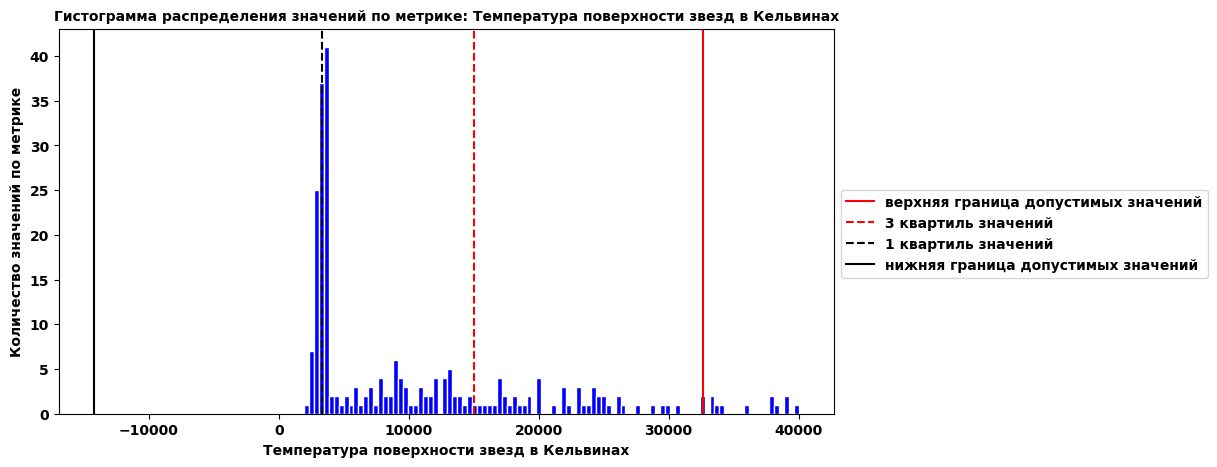

Верхняя допустимая граница значений: 32622.375
Нижняя допустимая граница значений: -14222.625
Медианное значение: 5776.0
Среднее значение: 10497.46
Доля значений, выходящих за верхнюю границу: 4.58%
Доля значений, выходящих за нижнюю границу: 0.00%


In [16]:
# построение  гистограммы распределения значений по признаку 'temperature'
histogram_plotting(stars, 'temperature', 100, 10, 5, 'Температура поверхности звезд в Кельвинах')

**Вывод по промежуточному этапу**

В наборе данных по рассматриваемому признаку - **temperature** - имеются аномально большие значения: **4.6%**
Вероятно, что подобные показатели принадлежат звездам главной последовательности, сверхгигантам и гипергигантам - в таком случае наблюдаемые значения не подлежат исключению.

In [17]:
# сводная таблица со средними температурами звезд в зависимости от типа
temp_pivot = stars.pivot_table(index = 'star_type', values = 'temperature', aggfunc = ['mean', 'median'])
temp_pivot.columns = ['temp_mean', 'temp_median']

temp_pivot.sort_values('temp_median', ascending = False)

,temp_mean,temp_median
star_type,,
2,13931.450,13380.0
4,15347.850,12821.0
3,16018.000,12560.5
5,11405.700,3766.0
1,3283.825,3314.0
0,2997.950,2935.0


In [18]:
# вывод уникальных типов звезд для аномально больших значений по признаку 'temperature'
print('Типы звезд с аномально большими значениями температуры:', 
      stars[stars['temperature'] > stars['temperature'].quantile(0.75) + 1.5 * (stars['temperature'].quantile(0.75) - stars['temperature'].quantile(0.25))]['star_type'].unique())

Типы звезд с аномально большими значениями температуры: [3 4 5]


**Вывод по промежуточному этапу**

По итогам анализа определено, что аномально **высокие температуры характерны для звезд типа 2, 3 и 4** (Белый карлик, Звезды главной последовательности и Сверхгиганты, соответственно).

**Наличие среди этих объектов звезды типа 5 - Сверхгигант - является уникальной ситуацией, но не подлежащей исключению из набора**.

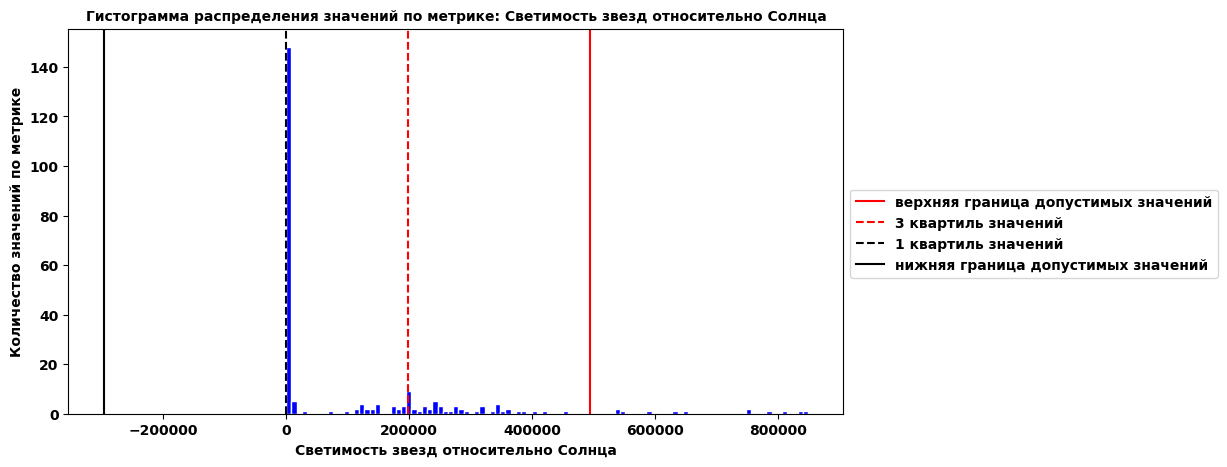

Верхняя допустимая граница значений: 495124.998702875
Нижняя допустимая граница значений: -297074.997838125
Медианное значение: 0.07050000000000001
Среднее значение: 107188.36
Доля значений, выходящих за верхнюю границу: 5.00%
Доля значений, выходящих за нижнюю границу: 0.00%


In [19]:
# построение  гистограммы распределения значений по признаку 'luminosity'
histogram_plotting(stars, 'luminosity', 100, 10, 5, 'Светимость звезд относительно Солнца')

**Вывод по промежуточному этапу**

Наблюдаются две обособленные от общей массы группы звезд, выходящие за верхнюю границу допустимых значений - 500 000
Необходимо изучить данные объекты для лучшего понимания природы такой картины.

In [20]:
# получение среза данных по объектам с аномально большой светимостью
max_luminosity = stars[stars['luminosity'] > stars['luminosity'].quantile(0.75) + 1.5 * (stars['luminosity'].quantile(0.75) - stars['luminosity'].quantile(0.25))]

# построение сводной таблицы по объектам с аномально большой светимостью
max_luminosity.groupby('star_type').agg({
    'temperature' : 'mean',
    'luminosity' : 'count'
})

,temperature,luminosity
star_type,,
4,21200.0,5
5,18548.0,7


**Вывод по промежуточному этапу**

Объекты с аномально большой светимостью относятся к типу 4 и 5 - **Сверхгиганты и Гипергиганты, соответственно**.

**Данные объекты не подлежат исключению из набора**.

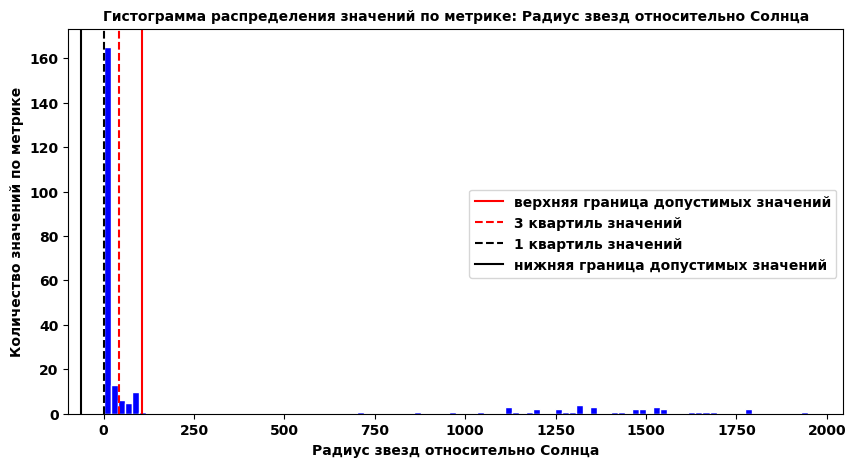

Верхняя допустимая граница значений: 106.720875
Нижняя допустимая граница значений: -63.868125
Медианное значение: 0.7625
Среднее значение: 237.16
Доля значений, выходящих за верхнюю границу: 16.67%
Доля значений, выходящих за нижнюю границу: 0.00%


In [21]:
# построение  гистограммы распределения значений по признаку 'radius'
histogram_plotting(stars, 'radius', 100, 10, 5, 'Радиус звезд относительно Солнца')

In [22]:
# получение среза данных по объектам с аномально большими радиусами относительно Солнца
max_radius = stars[stars['radius'] > stars['radius'].quantile(0.75) + 1.5 * (stars['radius'].quantile(0.75) - stars['radius'].quantile(0.25))]

# построение сводной таблицы по объектам с аномально большой светимостью
max_radius.groupby('star_type').agg({
    'temperature' : 'mean',
    'radius' : 'count'
})

,temperature,radius
star_type,,
5,11405.7,40


**Вывод по промежуточному этапу**

Объекты с аномально большими радиусами относительно Солнца относятся к типу 5 - **Гипергиганты**

**Данные объекты не подлежат исключению из набора**.

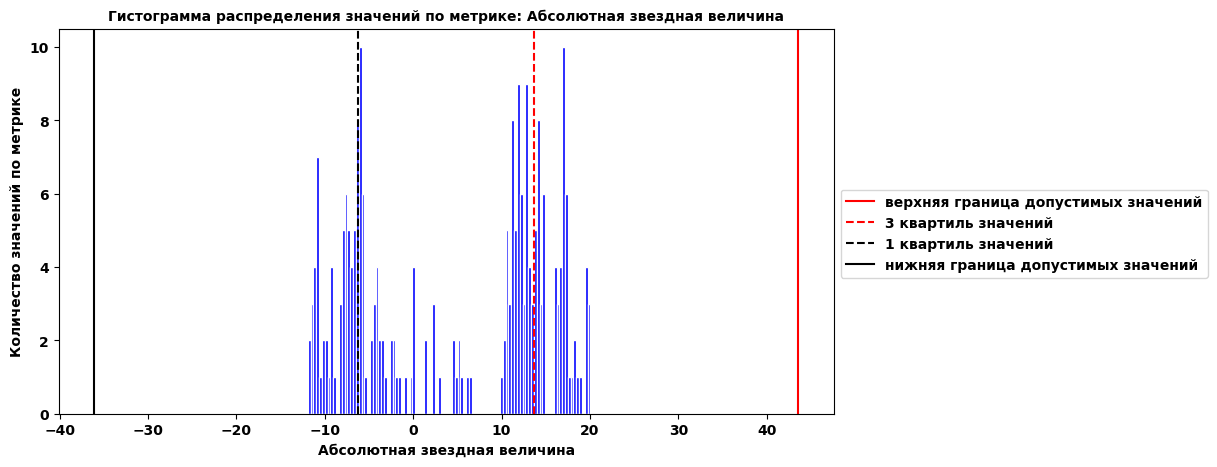

Верхняя допустимая граница значений: 43.5925
Нижняя допустимая граница значений: -36.1275
Медианное значение: 8.312999999999999
Среднее значение: 4.38
Доля значений, выходящих за верхнюю границу: 0.00%
Доля значений, выходящих за нижнюю границу: 0.00%


In [23]:
# построение  гистограммы распределения значений по признаку 'temperature'
histogram_plotting(stars, 'absolute_magnitude', 100, 10, 5, 'Абсолютная звездная величина')

**Вывод по промежуточному этапу**

Наблюдается **бимодальное распределение значений**, находящееся в пределах допустимых границ.

**Очистки набора данных от аномальных значений по данному признаку не требуется**

**Вывод**

**Вывод по промежуточному этапу**

1. Набор `stars` характеризуется следующими статистическими показателями:
    * **temperature - температура звезды в Кельвинах**:
        * Среднее значение - 10 497.5;
        * Минимальное значение - 1 939.0;
        * Максимальное значение - 40 000.0;
        * Стандартное отклонение - 9 552.4.
    * **luminosity - относительная светимость**:
        * Среднее значение - 107 188.4;
        * Минимальное значение - 0.0;
        * Максимальное значение - 849 420.0.
        * Стандартное отклонение - 179 432.2.
    * **radius - относительный радиус**:
        * Среднее значение - 237.2;
        * Минимальное значение - 0.0084;
        * Максимальное значение - 1 948.5;
        * Стандартное отклонение - 517.2.
    * **absolute_magnitude - абсолютная звездная величина**:
        * Среднее значение - 4.4;
        * Минимальное значение - -11.9;
        * Максимальное значение - 20.1;
        * Стандартное отклонение - 10.5.
2. Произведен анализ категориальных данных:
    * Большая часть звезд (87%) представлена тремя основными цветами: **red** (47%), **blue** (23%) и **blue-white** (17%);
    * Все звезды распределены в равном отношении друг к другу: **40 представителей в каждом из 6 типов**.
3. Проведен анализ количественных признаков:
    * Анализ признака **temperature**:
        * **Высокие температуры характерны для звезд типа 2, 3 и 4** (Белый карлик, Звезды главной последовательности и Сверхгиганты, соответственно);
        * **Наличие среди этих объектов звезды типа 5 - Сверхгигант - является уникальной ситуацией, но не подлежащей исключению из набора**.
    * Анализ признака **luminosity**:
        * Объекты с аномально большой светимостью относятся к типу 4 и 5 - **Сверхгиганты и Гипергиганты, соответственно**.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **radius**:
        * Объекты с аномально большими радиусами относительно Солнца относятся к типу 5 - **Гипергиганты**;
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **absolute_magnitude**:
        * Наблюдается **бимодальное распределение значений**, находящееся в пределах допустимых границ.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
4. Набор данных подготовлен к дальнейшему использованию в проектировании нейросети.

## Корреляционный анализ данных <a class = 'anchor' id = 'Корреляция'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Построение матрицы корреляции - поиск признаков высокой взаимосвязи показателей объектов;
2. Проведение отбора признаков для последующего построения моделей машинного обучения;
3. Формирование вывода по итогам данного этапа.

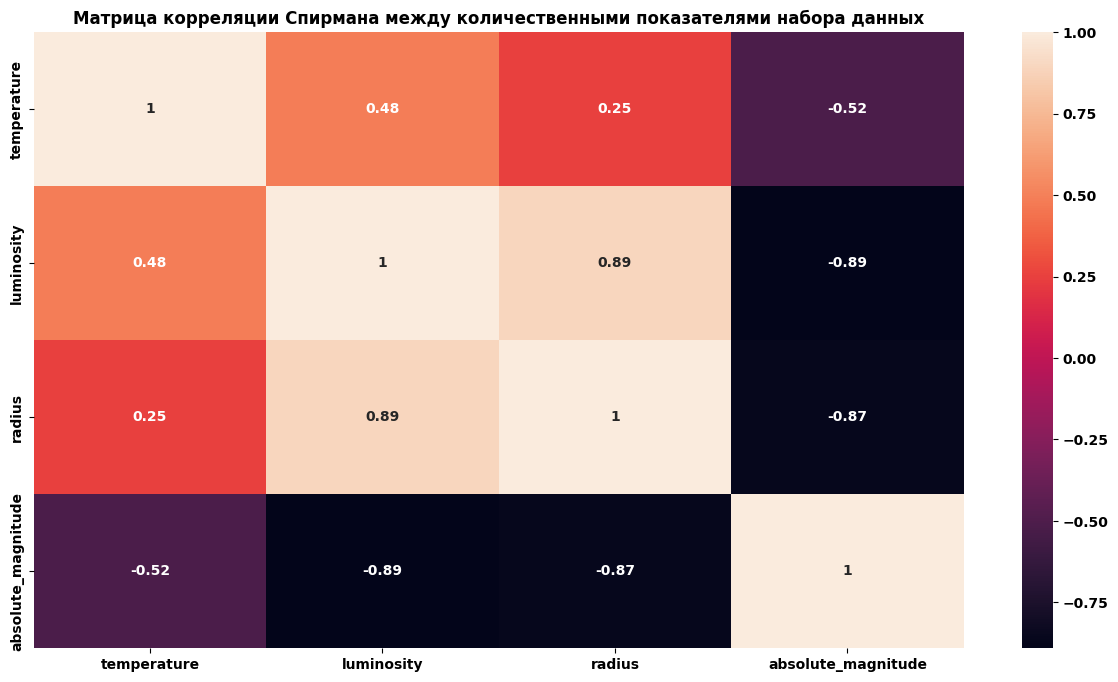

In [24]:
# построение матрицы корреляции и поиск сильных взаимосвязей
plt.figure(figsize=(15, 8))
sns.heatmap(stars.select_dtypes(include = 'number').drop('star_type', axis = 1).corr(method = 'spearman'), annot = True) # используется построение корреляции по Спирману, так как количественные значения не распределены нормально
plt.title('Матрица корреляции Спирмана между количественными показателями набора данных', fontsize = 12)
plt.show()

**Вывод по промежуточному этапу:**

Заметна линейная взаимосвязь (при анализе количественных показателей):
* между признаками и целевой переменной **temperature**:
    * **luminosity** - в большинстве случаев чем выше светимость звезды, тем выше температура;
    * **radius** - в большинстве случаев чем больше радиус, тем выше температура;
* между признаками:
    * **luminosity** и **radius** - чем больше радиус, тем больше светимость;
    * Взаимосвязь с признаком **absolute_magnitude** необходимо рассмотреть на корреляционной диграмме с учетом непрерывности значений по признаку, а также в связи с категориальными данными.

Требуется также рассмотреть взаимосвязь данных в **контексте учета категориальных показателей**.

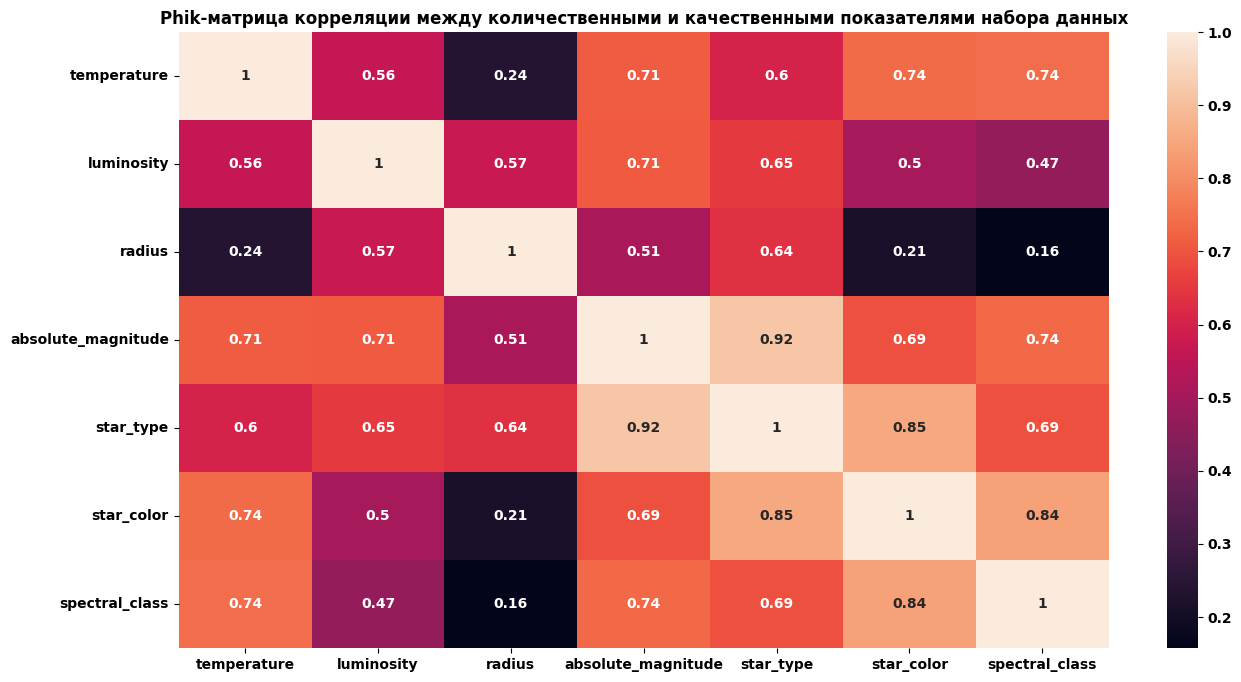

In [25]:
# построение матрицы корреляции по всем признакам
plt.figure(figsize=(15, 8))
(sns.heatmap(stars
             .phik_matrix(interval_cols = ['temperature', 'luminosity', 'radius', 'absolute_magnitude']), annot = True))
plt.title('Phik-матрица корреляции между количественными и качественными показателями набора данных', fontsize = 12)
plt.show()

**Вывод по промежуточному этапу:**

При анализе матрицы корреляции по **количественным и качественным признакам** заметна линейная взаимосвязь:
* между признаками и целевой переменной **temperature** наблюдается умеренная связь;
* между признаками **star_type** и **absolute_magnitude**; **star_color** и **star_type** наблюдается сильная связь;

В целом, все признаки неплохо хорошо коррелируют между собой, что в потенциале повышает шансы на верные прогнозы целевой переменной.

**Вывод**

1. Построена матрица корреляции Спирмана - произведен анализ взаимосвязей:
    * между признаками и целевой переменной **temperature**:
        * **luminosity** - в большинстве случаев чем выше светимость звезды, тем выше температура;
        * **radius** - в большинстве случаев чем больше радиус, тем выше температура;
    * между признаками:
        * **luminosity** и **radius** - чем больше радиус, тем больше светимость;
        * Взаимосвязь с признаком **absolute_magnitude** необходимо рассмотреть на корреляционной диграмме с учетом непрерывности значений по признаку, а также в связи с категориальными данными.
2. Построена Phik-матрица корреляции - произведен анализ взаимосвязей **количественных и качественных** признаков с целевой переменной:
    * между признаками и целевой переменной **temperature** наблюдается умеренная связь;
    * между признаками **star_type** и **absolute_magnitude**; **star_color** и **star_type** наблюдается сильная связь;

В целом, **все признаки неплохо хорошо коррелируют между собой и целевой переменной**, что в потенциале повышает шансы на верные прогнозы целевой переменной.

## Построение моделей машинного обучения <a class = 'anchor' id = 'Моделирование'></a>

### Подготовка данных <a class = 'anchor' id = 'Моделирование_подготовка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Инициализация пользовательской функции подготовки данных:
    * Разделение исходного набора `stars` на область признаков и вектор целевой переменной - инициализация переменных `X` и **y** соответственно;
    * Инициализация переменных `X_train`, `X_test`, **y_train** и **y_test** для хранения обучающих и тестовых наборов данных;
    * Масштабирование количественных значений стратегией стандартизации;
    * Кодирование категориальных значений стратегиями OneHotEncoding и OrdinalEncoding;
    * Объединение обработанных значений в общие наборы данных - перезапись переменных `X_train` и `X_test`;
2. Отбор категориальных и количественных значений в отдельные переменные - инициализация переменных **ohe_cols**, **ord_cols** и **num_cols**;
3. Преобразование исходного набора данных;
4. Формирование вывода по итогам данного этапа.

In [26]:
# инициализация пользовательской функции расчета модели линейной регрессии
def data_preparing (df : pd.DataFrame, num_col_names : list, ohe_col_names : list, ord_col_names : list):
    
    # формирование области признаков и вектора целевой переменной
    X = df.drop('temperature', axis = 1)
    y = df['temperature']

    # разделение набора данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE
    )

    # инициализация переменной 'scaler'
    scaler = StandardScaler()

    # инициализация переменной 'ohe_encoder'
    ohe_encoder = OneHotEncoder(sparse_output = False,
                            drop = 'first',
                            handle_unknown = 'ignore')
    
    # инициализация переменной 'ord_encoder'
    ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

    # масштабирование количественных признаков в выборках
    X_train_sc = scaler.fit_transform(X_train[num_col_names])
    X_test_sc = scaler.transform(X_test[num_col_names])

    # кодирование категориальных признаков
    X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_col_names])
    X_test_ohe = ohe_encoder.transform(X_test[ohe_col_names])

    X_train_ord = ord_encoder.fit_transform(X_train[ord_col_names])
    X_test_ord = ord_encoder.transform(X_test[ord_col_names])

    # список новых столбцов после кодирования признаков
    encoder_col_names = ohe_encoder.get_feature_names_out()

    # создание новых датафреймов после кодирования
    X_train_ohe = pd.DataFrame(X_train_ohe, columns = encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns = encoder_col_names)

    X_train_ord = pd.DataFrame(X_train_ord, columns = ord_col_names)
    X_test_ord = pd.DataFrame(X_test_ord, columns = ord_col_names)

    # создание новых датафреймов после масштабирования
    X_train_sc = pd.DataFrame(X_train_sc, columns = num_col_names)
    X_test_sc = pd.DataFrame(X_test_sc, columns = num_col_names)

    # объединение наборов данных
    X_train = pd.concat([X_train_ohe, X_train_ord, X_train_sc], axis = 1)
    X_test = pd.concat([X_test_ohe, X_test_ord, X_test_sc], axis = 1)

    return X_train, X_test, y_train, y_test

In [27]:
# инициализация переменных для хранения названий признаков в соответствующих категориях
ohe_cols = ['star_color']
ord_cols = ['star_type']
num_cols = ['absolute_magnitude', 'radius', 'luminosity']

# преобразование наборов
X_train, X_test, y_train, y_test = data_preparing(stars, num_cols, ohe_cols, ord_cols)

**Вывод**

1. Инициализирована пользовательской функция - **data_preparing** - подготовки данных, в которой выполняется:
    * Разделение исходного набора `stars` на область признаков и вектор целевой переменной - инициализация переменных `X` и **y** соответственно;
    * Инициализация переменных `X_train`, `X_test`, **y_train** и **y_test** для хранения обучающих и тестовых наборов данных;
    * Масштабирование количественных значений стратегией стандартизации;
    * Кодирование категориальных значений стратегиями OneHotEncoding и OrdinalEncoding;
    * Объединение обработанных значений в общие наборы данных - перезапись переменных `X_train` и `X_test`;
2. Произведен отбор категориальных и количественных значений в отдельные переменные - инициализированы переменные **ohe_cols**, **ord_cols** и **num_cols**;
3. Выполнено преобразование исходного набора данных.

### Построение baseline-модели прогнозирования на базе нейронной сети <a class = 'anchor' id = 'Моделирование_baseline'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Ввод переменных для задания констант, формирующих нейронную сеть:
    * Количество скрытых слоев;
    * Количество нейронов;
    * Функции активации на скрытых и выходном слоях
2. Создание класса для задания архитектуры нейронной сети;
3. Инициализация пользовательских функций обучения / тестирования модели;
4. Инициализация пользовательской функции построения графика прогноз / факт;
5. Инициализация пользовательской функции генерации весов;
6. Преобразование входных данных в тензоры PyTorch
7. Обучение нейронной сети и проверка качества прогнозов на тестовой выборке
8. Формирование вывода по итогам данного этапа.

In [28]:
# задание константных значений для формирования нейронной сети
n_in_neurons = len(X_train.columns)
n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 5
n_out_neurons = 1

In [29]:
# Создание класса нейронной сети с 3 скрытыми слоями
class NeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация нейросети
net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

In [30]:
# инициализация оптимизатора
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)
# функция потерь
loss = nn.MSELoss()
# количество эпох обучения
num_epochs = 9_001

In [31]:
# Функция обучения модели
def model_training(train_x, train_y):
    optimizer.zero_grad()
    preds = net.forward(train_x).flatten()
    
    # L2-Регуляризация весов
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
    loss_value = torch.sqrt(loss(preds, train_y)) + l2_lambda * l2_norm
    loss_value.backward()

    optimizer.step()

# Функция тестирования модели
def model_testing(epoch):
    net.eval()
    test_preds = net.forward(X_test).flatten()
    print('Epoch #:', epoch)
    print('RMSE =', torch.sqrt(loss(test_preds, y_test)).item(), '\n')
    return test_preds

In [32]:
# Функция для обучения с использованием батчей
def batch_training(epochs_num, epoch_test):
    batch_size = 100
    num_batches = math.ceil(len(X_train) / batch_size)

    for epoch in range(epochs_num):
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            
            optimizer.zero_grad()

            batch_indexes = order[start_idx:start_idx + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            model_training(X_batch, y_batch)
        if epoch % epoch_test == 0:
            y_pred = model_testing(epoch)
    return y_pred

In [33]:
# Функция для отображения графика "Факт-Прогноз"
def show_graph(y_pred):
    start = 0
    end = 15
    
    basic_df = y_test[start:end]
    nn_df = y_pred[start:end]

    plt.figure(figsize=(7, 7))
    plt.bar(range(start, end), nn_df.detach().numpy(), color='orange', label='Прогноз')
    plt.bar(range(start, end), basic_df, color='blue', width=0.5, label='Факт')

    plt.legend()
    plt.title('Факт-Прогноз', fontsize=16)
    plt.xlabel('Номер звезды в таблице данных', fontsize=14)
    plt.ylabel('Температура звезды', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [34]:
# Функция для инициализации весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        )

# Инициализация весов нейросети
net.apply(init_weights)

NeuralNet(
  (fc1): Linear(in_features=9, out_features=8, bias=True)
  (ac1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (ac2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (ac3): LeakyReLU(negative_slope=0.01)
)

In [35]:
# преобрзование входных данных в тензоры PyTorch
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [36]:
# обучение модели нейронной сети
for epoch in range(num_epochs):
    model_training(X_train, y_train)
    if epoch % 1_000 == 0 or epoch == num_epochs - 1:
        preds = model_testing(epoch)

Epoch #: 0
RMSE = 14626.484375 

Epoch #: 1000
RMSE = 14033.83203125 

Epoch #: 2000
RMSE = 11529.1171875 

Epoch #: 3000
RMSE = 9356.48828125 

Epoch #: 4000
RMSE = 8476.6162109375 

Epoch #: 5000
RMSE = 7942.3857421875 

Epoch #: 6000
RMSE = 7594.3095703125 

Epoch #: 7000
RMSE = 7339.328125 

Epoch #: 8000
RMSE = 7087.64697265625 

Epoch #: 9000
RMSE = 6648.5849609375 



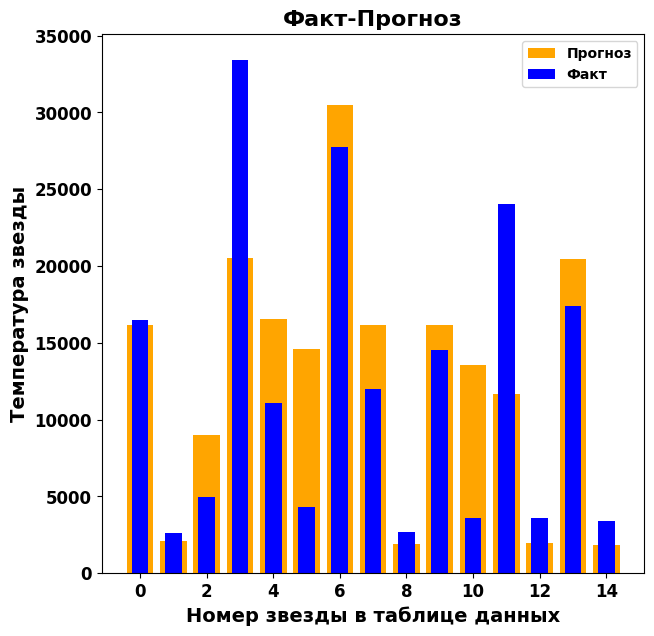

In [37]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(preds)

**Вывод**

1. Введены переменные для задания констант, формирующих нейронную сеть:
    * Количество скрытых слоев - **2**;
    * Количество нейронов:
        * На входном слое - **равно количеству признаков модели**;
        * На 1 скрытом слое - **8**;
        * На 2 скрыто слое - **5**;
        * На выходном слое - **1**.
    * Функции активации на скрытых и выходном слоях - **LeakyReLU**;
2. Создан класс для задания архитектуры нейронной сети;
3. Инициализированы пользовательские функции обучения / тестирования модели;
4. Инициализированы пользовательские функции построения графика прогноз / факт;
5. Инициализированы пользовательские функции генерации весов;
6. Преобразованы входные данные в тензоры PyTorch;
7. Проведены обучение нейронной сети и проверка качества прогнозов на тестовой выборке:
    * **На эпохе под номером 9 000 метрика RMSE составляет - 7 064**.

### Построение улучшенной модели нейронной сети <a class = 'anchor' id = 'Моделирование_улучшение'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Улучшение модели нейронной сети через **использование батчей**;
2. Улучшение модели нейронной сети через **использование метода Batch Normalization**;
3. Улучшение модели нейронной сети через **использование метода DropOut**.

#### Изменение размера батчей <a class = 'anchor' id = 'Моделирование_улучшение_батчи'></a>

In [38]:
# Создание класса нейронной сети с 3 скрытыми слоями
class ImprovedNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(ImprovedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация сети и весов для нее
net = ImprovedNeuralNet(n_in_neurons,
                        n_hidden_neurons_1,
                        n_hidden_neurons_2,
                        n_out_neurons)
net.apply(init_weights)

# Новая инициализация оптимизатора (поскольку используется новая модель)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Тренировка и тестирование нейросети с использованием батчей
batch_nn_preds = batch_training(epochs_num=15001, epoch_test=1000)

Epoch #: 0
RMSE = 14626.6220703125 

Epoch #: 1000
RMSE = 12077.2802734375 

Epoch #: 2000
RMSE = 8849.3935546875 

Epoch #: 3000
RMSE = 7927.71484375 

Epoch #: 4000
RMSE = 7432.40283203125 

Epoch #: 5000
RMSE = 7161.0966796875 

Epoch #: 6000
RMSE = 6878.8994140625 

Epoch #: 7000
RMSE = 6552.580078125 

Epoch #: 8000
RMSE = 6175.7236328125 

Epoch #: 9000
RMSE = 5835.36669921875 

Epoch #: 10000
RMSE = 5662.78759765625 

Epoch #: 11000
RMSE = 5584.27392578125 

Epoch #: 12000
RMSE = 5530.02294921875 

Epoch #: 13000
RMSE = 5473.37109375 

Epoch #: 14000
RMSE = 5423.7060546875 

Epoch #: 15000
RMSE = 5375.25390625 



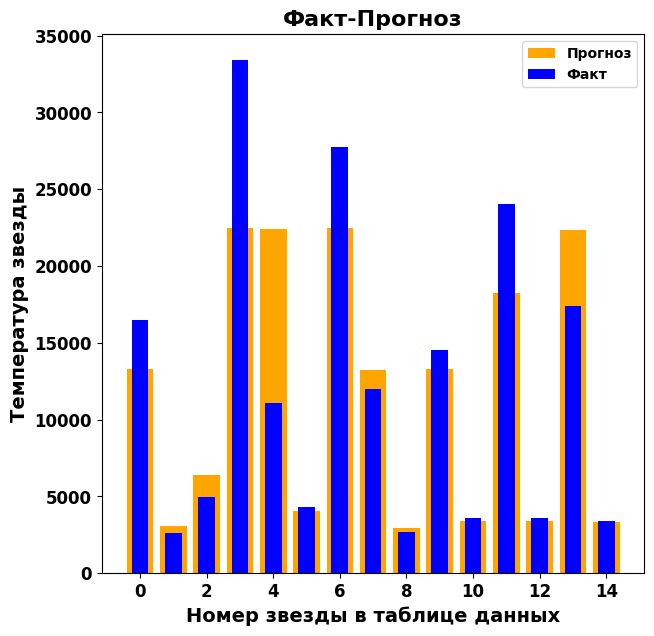

In [39]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(batch_nn_preds)

**Вывод по промежуточному этапу**

При использовании метода обучения нейронной сети через регуляризацию размера батчей, а также при изменении количества эпох обучения удалось улучшить значение метрики RMSE на тестовом наборе данных при прогнозировании температуры звезд:

**С 7 064 до 5 375 К**

#### Метод Batch Normalization <a class = 'anchor' id = 'Моделирование_улучшение_BatchNorm'></a>

In [40]:
#  Создание улучшенной нейросети с нормализацией батчей
class BatchImprovedNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(BatchImprovedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.batch1 = nn.BatchNorm1d(hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.batch2 = nn.BatchNorm1d(hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.batch3 = nn.BatchNorm1d(out_neurons)
        self.ac3 = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.batch2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.batch3(x)
        x = self.ac3(x)
        return x


# Инициализация модели, весов и оптимизатора
net = BatchImprovedNeuralNet(n_in_neurons,
                             n_hidden_neurons_1,
                             n_hidden_neurons_2,
                             n_out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

# Релизация обучения с помощью батчей
batch_norm_nn_preds = batch_training(epochs_num = 10_001, epoch_test = 500)

Epoch #: 0
RMSE = 14626.8671875 

Epoch #: 500
RMSE = 9123.16796875 

Epoch #: 1000
RMSE = 7535.02880859375 

Epoch #: 1500
RMSE = 6809.1083984375 

Epoch #: 2000
RMSE = 6076.50830078125 

Epoch #: 2500
RMSE = 5631.28125 

Epoch #: 3000
RMSE = 5488.228515625 

Epoch #: 3500
RMSE = 5456.50390625 

Epoch #: 4000
RMSE = 5377.8408203125 

Epoch #: 4500
RMSE = 5260.9970703125 

Epoch #: 5000
RMSE = 5120.72802734375 

Epoch #: 5500
RMSE = 4989.66748046875 

Epoch #: 6000
RMSE = 4829.6123046875 

Epoch #: 6500
RMSE = 4672.51220703125 

Epoch #: 7000
RMSE = 4523.986328125 

Epoch #: 7500
RMSE = 4421.08642578125 

Epoch #: 8000
RMSE = 4290.69482421875 

Epoch #: 8500
RMSE = 4229.810546875 

Epoch #: 9000
RMSE = 4200.66796875 

Epoch #: 9500
RMSE = 4159.2197265625 

Epoch #: 10000
RMSE = 4125.25341796875 



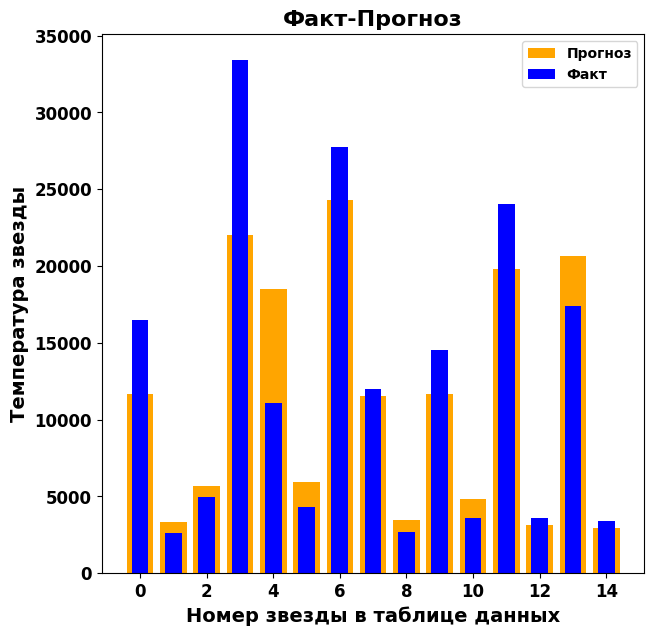

In [41]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(batch_norm_nn_preds)

**Вывод по промежуточному этапу**

При использовании метода Batch Normalization улучшения нейронной сети, а также при изменении количества эпох обучения удалось улучшить значение метрики RMSE на тестовом наборе данных при прогнозировании температуры звезд:

**С 7 064 К** на baseline-модели до **4 125 К** на текущей версии.

При такой модификации модели нейронной сети **удалось пройти требуемый порог в 4 500 К**.

#### Метод Dropout <a class = 'anchor' id = 'Моделирование_улучшение_dropout'></a>

In [42]:
# Создание класса нейронной сети с Dropout ("выключением" нейронов)
class DropoutNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(DropoutNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.drop1 = nn.Dropout(p=0.6)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.drop2 = nn.Dropout(p=0.6)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация модели, весов, оптимизатора
net = DropoutNeuralNet(n_in_neurons,
                       n_hidden_neurons_1,
                       n_hidden_neurons_2,
                       n_out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

dropout_nn_preds = batch_training(epochs_num = 15001, epoch_test = 1000)

Epoch #: 0
RMSE = 14626.6171875 

Epoch #: 1000
RMSE = 11594.546875 

Epoch #: 2000
RMSE = 8603.11328125 

Epoch #: 3000
RMSE = 7756.9638671875 

Epoch #: 4000
RMSE = 7302.66455078125 

Epoch #: 5000
RMSE = 7006.37158203125 

Epoch #: 6000
RMSE = 6556.01171875 

Epoch #: 7000
RMSE = 6151.40673828125 

Epoch #: 8000
RMSE = 5876.70947265625 

Epoch #: 9000
RMSE = 5701.09912109375 

Epoch #: 10000
RMSE = 5582.0478515625 

Epoch #: 11000
RMSE = 5558.505859375 

Epoch #: 12000
RMSE = 5521.966796875 

Epoch #: 13000
RMSE = 5472.50390625 

Epoch #: 14000
RMSE = 5419.94775390625 

Epoch #: 15000
RMSE = 5364.0126953125 



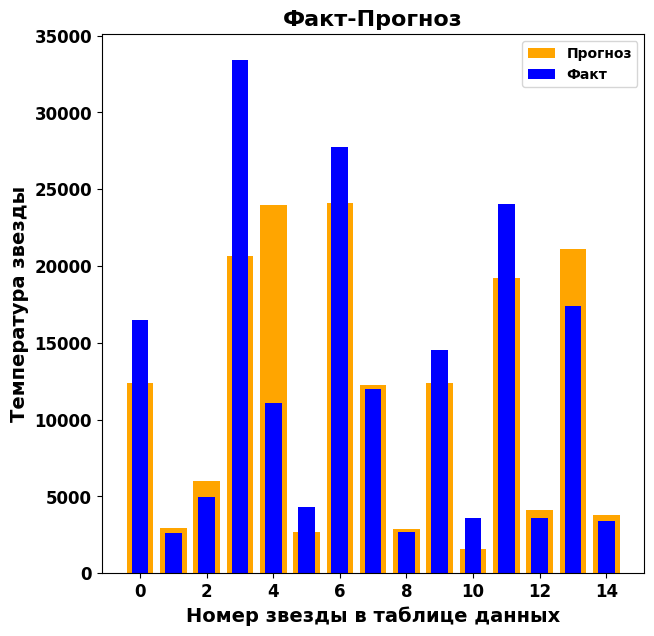

In [43]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(dropout_nn_preds)

**Вывод по промежуточному этапу**

При использовании метода Dropout улучшения нейронной сети, а также при изменении количества эпох обучения удалось улучшить значение метрики RMSE на тестовом наборе данных при прогнозировании температуры звезд:

**С 7 064 К** на baseline-модели до **5 364 К** на текущей версии.

При такой модификации модели нейронной сети **не удалось пройти требуемый порог в 4 500 К**.

**Вывод**

1. Проведено улучшение модели нейронной сети через **использование батчей**:
    * Достигнут показатель RMSE на тестовой выборке - **5 375 К**.
2. Проведено улучшение модели нейронной сети через **использование метода Batch Normalization**:
    * Достигнут показатель RMSE на тестовой выборке - **4 125 К**.
3. Проведено улучшение модели нейронной сети через **использование метода DropOut**:
    * Достигнут показатель RMSE на тестовой выборке - **5 364 К**.

## Общий вывод <a class = 'anchor' id = 'Вывод'></a>

**Вывод**

1. Импортированы библиотеки Python:
    * для манипулирования данными:
        * pandas;
        * numpy.
    * для визуализации данных:
        * matplotlib.pyplot;
        * seaborn;
        * plotly;
        * dash.
    * для вычисления корреляции данных:
        * phik_matrix.
    * для решения задач машинного обучения:
        * механизмы построения нейронной сети:
            * torch.nn.
        * метрики оценки эффективности моделей классификации;
        * train_test_split - механизм разделения данных;
        * StandardScaler - стандартизация данных;
        * OneHotEncoder - one-hot кодирование категориальных признаков;
        * OrdinalEncoder - кодирование значений ранговых признаков.
2. Инициализированы переменные **RANDOM_STATE** и **TEST_SIZE** для фиксирования "случайности" и размера тестовой выборки.
3. Произведена загрузка данных в рабочую среду Jupyter Notebook. Инициализирована переменная **stars**;
4. Выведены на экран параметры датасета:
    * В наборе данных **отсутствуют пустые значения** по признакам;
    * Типы данных **соответствуют сущностям значений** по всем рассматриваемым признакам;
    * Названия столбцов **необходимо привести к формату snake_case**;
    * Наблюдаются неявные дубликаты по признаку **Star color**;
    * Наблюдаются выбросы по количественным признакам:
        * **Temperature (K)**;
        * **Luminosity (L/Lo)**;
        * **Radius (R/Ro)**.
    * Самые популярные категории по спектральному классу: **M, B** и **O**;
    * Самые популярные цвета звезд: **Red**, **Pale yellow orange** и **Blue**.
5. Названия столбцов приведены к формату snake_case;
6. Обработаны неявные дубликаты - значения - по признаку **Star color**:
    * Понижен регистр значений;
    * Удалены пробелы в конце строк;
    * Заменены пробелы на дефис;
    * Заменены значения с перестановкой цвета.
7. Проверка датасетов на явные дубликаты - **Явные дубликаты отсутствуют**;
8. Набор `stars` характеризуется следующими статистическими показателями:
    * **temperature - температура звезды в Кельвинах**:
        * Среднее значение - 10 497.5;
        * Минимальное значение - 1 939.0;
        * Максимальное значение - 40 000.0;
        * Стандартное отклонение - 9 552.4.
    * **luminosity - относительная светимость**:
        * Среднее значение - 107 188.4;
        * Минимальное значение - 0.0;
        * Максимальное значение - 849 420.0.
        * Стандартное отклонение - 179 432.2.
    * **radius - относительный радиус**:
        * Среднее значение - 237.2;
        * Минимальное значение - 0.0084;
        * Максимальное значение - 1 948.5;
        * Стандартное отклонение - 517.2.
    * **absolute_magnitude - абсолютная звездная величина**:
        * Среднее значение - 4.4;
        * Минимальное значение - -11.9;
        * Максимальное значение - 20.1;
        * Стандартное отклонение - 10.5.
9. Произведен анализ категориальных данных:
    * Большая часть звезд (87%) представлена тремя основными цветами: **red** (47%), **blue** (23%) и **blue-white** (17%);
    * Все звезды распределены в равном отношении друг к другу: **40 представителей в каждом из 6 типов**.
10. Проведен анализ количественных признаков:
    * Анализ признака **temperature**:
        * **Высокие температуры характерны для звезд типа 2, 3 и 4** (Белый карлик, Звезды главной последовательности и Сверхгиганты, соответственно);
        * **Наличие среди этих объектов звезды типа 5 - Сверхгигант - является уникальной ситуацией, но не подлежащей исключению из набора**.
    * Анализ признака **luminosity**:
        * Объекты с аномально большой светимостью относятся к типу 4 и 5 - **Сверхгиганты и Гипергиганты, соответственно**.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **radius**:
        * Объекты с аномально большими радиусами относительно Солнца относятся к типу 5 - **Гипергиганты**;
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **absolute_magnitude**:
        * Наблюдается **бимодальное распределение значений**, находящееся в пределах допустимых границ.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
11. Инициализирована пользовательской функция - **data_preparing** - подготовки данных, в которой выполняется:
    * Разделение исходного набора `stars` на область признаков и вектор целевой переменной - инициализация переменных `X` и **y** соответственно;
    * Инициализация переменных `X_train`, `X_test`, **y_train** и **y_test** для хранения обучающих и тестовых наборов данных;
    * Масштабирование количественных значений стратегией стандартизации;
    * Кодирование категориальных значений стратегиями OneHotEncoding и OrdinalEncoding;
    * Объединение обработанных значений в общие наборы данных - перезапись переменных `X_train` и `X_test`;
12. Произведен отбор категориальных и количественных значений в отдельные переменные - инициализированы переменные **ohe_cols**, **ord_cols** и **num_cols**;
13. Выполнено преобразование исходного набора данных;
14. Введены переменные для задания констант, формирующих нейронную сеть:
    * Количество скрытых слоев - **2**;
    * Количество нейронов:
        * На входном слое - **равно количеству признаков модели**;
        * На 1 скрытом слое - **8**;
        * На 2 скрыто слое - **5**;
        * На выходном слое - **1**.
    * Функции активации на скрытых и выходном слоях - **LeakyReLU**;
15. Создан класс для задания архитектуры нейронной сети;
16. Инициализированы пользовательские функции обучения / тестирования модели;
17. Инициализированы пользовательские функции построения графика прогноз / факт;
18. Инициализированы пользовательские функции генерации весов;
19. Преобразованы входные данные в тензоры PyTorch;
20. Проведены обучение нейронной сети и проверка качества прогнозов на тестовой выборке:
    * **На эпохе под номером 9 000 метрика RMSE составляет - 7 064**.
21. Проведено улучшение модели нейронной сети через **использование батчей**:
    * Достигнут показатель RMSE на тестовой выборке - **5 375 К**.
22. Проведено улучшение модели нейронной сети через **использование метода Batch Normalization**:
    * Достигнут показатель RMSE на тестовой выборке - **4 125 К**.
23. Проведено улучшение модели нейронной сети через **использование метода DropOut**:
    * Достигнут показатель RMSE на тестовой выборке - **5 364 К**.